# Peer-based experience-good evaluation

The following code X a general computational model of social influence and decision making under adoption uncertainty.

### Purpose.

There are many products, actions or ideas that once we adopt them the consequences are highly unprectible or uncertain. Products available in the market usually present a risk for the consumer and they need to look for any source to rely on. Although almost all products have a variation in quality, they usually have a steady value. On the other hand we have experience goods, products which are usually consumed once and have higher quality fluctuations within their category. The main source to evaluate this products is through others opinions (i.e. critics, reviews, peers). The following model attempts to address how consumers make purchase decisions based on peer information.

### Model.

Consider on one side a set of C consumers where each individual has a particular vector of preference values. On the other side we have P products that also have an individual vector to represent feature values. To evaluate a product a consumer will compare its preferences with the product features. As consumers can't address products without purchasing them, they attempt to pre-evaluate via peer information. All consumers build expectations based on other consumers expectations or realized expectations (product value based on preferences). 

A detailed description of the model is LaTeX

### Agent-based implementation.

There are two agents: Consumers (A) and Products (P). 

#### Variables:

Population (A,P).

Agent's expectation.

Purchase Threshold (T): Individual (endogenous, random) or General (exogenous, fixed).

Agent's network structure.

Allow purchase.

#### Experiments:
All experiments have two versions according to agent's network structure: 1) Circle (1D), 2) Lattice (2D).

0 - Get probability distribution of realized expectation outcomes(i.e. personal experience value).

1 - "Default/Normal" run. Set an individual T and let agents purchase anytime.

2 - Test basic neighbor influence of expectation. Disable purchase, for a single agent fix the maximum expectation. Try for negative and positive expectation.

3 - Expectation dynamics pre and post product availability.

In [152]:
#Required libraries

import random as rd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [503]:
#Two main agent classes

class agent():
    def __init__(self,i):
        self.ID          = i
        self.expectative = [0 for j in range(S)]
        self.old_expect  = [0 for j in range(S)]
        self.store       = [0 for j in range(S)]
        self.preferences = [rd.uniform(-1,1) for i in range(Q)]
        self.bought      = [0 for j in range(S)]
        self.neighbors   = []
        self.position    = [0,0]
        if Thresh_type == 'general':      self.thresh  = T
        elif Thresh_type == 'individual': self.thresh  = rd.uniform(-1,1)

    def step(self):
        self.pre_evaluation()

    def update(self):
        for p in range(S):
            if self.bought[p] == 0:
                self.expectative[p] = self.store[p]
        
    def pre_evaluation(self):
        for p in range(S):
            if self.bought[p] == 0:
                others_expectatives = [a.expectative[p] for a in self.neighbors]
                self.store[p] = np.average(others_expectatives+[self.expectative[p]])
                self.store[p] = np.clip(self.store[p],-1,1)
                if self.expectative[p] > self.thresh and p in buyable:
                    self.buy(p)
                
    def post_evaluation(self,p):
        #Normalize product features vector and preferences vector. Return dot product of both.
        prod_features = P[p].features
        normalized_feat = prod_features / np.linalg.norm(prod_features)
        normalized_pref = self.preferences / np.linalg.norm(self.preferences)
        result = np.dot(normalized_feat,normalized_pref)
        return result
        
    def buy(self,p):
        result = self.post_evaluation(p)
        self.old_expect[p] = self.expectative[p]
        self.expectative[p] = result
        self.bought[p] = 1 
            
class product():
    def __init__(self):
        self.features = [rd.uniform(-1,1) for i in range(Q)]

In [504]:
#General functions

#Arrange network according to dimensional layout (1D,2D)
def position_arrange(A):
    if net == 'circle':
        for a in range(len(A)):
            A[a-1].neighbors = [A[a-2],A[a]]
        return A
    
    if net == 'lat':
        #Lattice network space
        Ids = iter([a for a in range(D)])
        n = int(np.sqrt(D))
        Lattice = [[A[Ids.next()] for x in range(n)] for y in range(n)] 

        #Update agents position
        for x in range(n):
            for y in range(n):
                Lattice[x][y].position = [x-1,y-1]

        #Update agents neighbors
        for a in A:
            posx,posy = a.position
            a.neighbors = [Lattice[posx-1][posy],Lattice[posx+1][posy],\
                           Lattice[posx][posy-1],Lattice[posx][posy+1]]
            
    return A

#Default setup creates consumer and product sets. Returns agent sets and two record keeping lists
def default_setup():
    #Collection of Agents (A) and Products (P)
    A = [agent(i) for i in range(D)]
    P = [product() for i in range(S)]
    
    #Arrange network
    A = position_arrange(A)

    #Simulation and data
    total_expectative = {str(p):[0] for p in range(S)}
    total_bought      = {str(p):[0] for p in range(S)} 
    
    return A,P,total_expectative,total_bought

#Simulation loop. Run model and plot states at beginning,33%,66% and 99% of total steps.
def sim_go(steps,A,P,go=None):
    global buyable, total_bought, total_expectative
    buyable = []
    if go == None:
        buyable = [i for i in range(S)]
    for s in range(steps):
        if go == s:
            buyable = [i for i in range(S)]
        for a in A:
            a.step()
        for a in A:
            a.update()
        for p in range(S):
            total_expectative[str(p)].append(sum([a.expectative[p] for a in A]))
            total_bought[str(p)].append(sum([a.bought[p] for a in A]))
        #plot_by_steps
        if s in [1,int(steps*.33),int(steps*.66),int(steps*.99)]:
            plot_circle_expect()
            plt.show()

    #Plot aggregated attitude value for each product. Add total purchases for each prod
    for p in range(S):
        plt.plot(total_expectative[str(p)])
        plt.plot(total_bought[str(p)],'--')
    plt.ylim(-len(A),len(A))
    plt.show()

In [525]:
#Plot functions
def plot_circle_expect():
    if net == 'circle':
        for p in range(S):
            fig = plt.figure(figsize=(9,5))
            print 'Product '+str(p)
            #Get old expectatives if already bought
            plt.scatter(np.arange(0.5,0.5+len(A)),[a.old_expect[p] for a in A],c='black',s=4)
            plt.plot(np.arange(0.5,0.5+len(A)),[a.old_expect[p] for a in A],c='black')
            #Get utility for all agents
            utility = [a.post_evaluation(p) for a in A]
            plt.scatter(np.arange(0.5,0.5+len(A)),utility,c='green',alpha=0.5,s=4)
            plt.plot(np.arange(0.5,0.5+len(A)),utility,c='green',alpha=0.5)
            
            #Plot expectatives for all (utility and pre-purchase)
            plt.bar(np.arange(0,len(A)),[a.expectative[p] for a in A],width=1,alpha=0.5)
            #Plot only owner bars, mark them as red
            owner_expect = []
            for a in A:
                if a.bought[p] == 1:
                    owner_expect.append(a.expectative[p])
                else:
                    owner_expect.append(0)
            plt.bar(np.arange(0,len(A)),owner_expect,width=1,color='r',alpha=0.5)
            plt.ylim(-1,1)
            plt.xlim(0,len(A))
            plt.show()
            
    if net == 'lat':
        for p in range(S):
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            #Get expectative values    
            Ids = iter([a for a in range(D)])
            n = int(np.sqrt(D))
            Expec_Lattice = [[float(A[Ids.next()].expectative[p]) for x in range(n)] for y in range(n)]
            x_val = np.arange(0,n)#[a.position[0] for a in A]
            y_val = np.arange(0,n)#[a.position[1] for a in A]
            x_val,y_val = np.meshgrid(x_val,y_val)
            z_val = np.array(Expec_Lattice)
            surf = ax.plot_surface(x_val, y_val, z_val, rstride=1, cstride=1, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
            ax.set_zlim(-1.01, 1.01)
            plt.show()

Default setup initialization and description.

In [275]:
#D = Size of demand. Number of individuals.
D=100

#S = Size of supply. Number of different products in the market.
S=1

#Q = Size of products features. Products are heterogenous; same number features but different values 
Q=2

#Thresh_type = Type of threshold used in the simulation. Individual is random and endogenous. General is fixed and exogenous
Thresh_type = 'general'

#T = Expectative threshold
T=0.01

#Steps = Simulation cycles
Steps=5000

#Net = Positional arrange. Circle is 1D circle. Lattice is a 2D thorus.
net='circle'    

#Buyable = List of product available for purchase.
buyable = [i for i in range(S)]

#Call default setup
A,P,total_expectative,total_bought = default_setup()

# Experiment 0

Distribution of Experience/Realized Expectatives (post-buy) is dependent on dot-product. Vector size of Preferences and Product Features is set at Q. Dot-product is based on two vectors of size Q.

In [449]:
#Experiment 0 Setup
D=100000
S=1
Thresh_type = 'general'
T=0.001
net='circle'
Steps=5000

In [450]:
def experiment0():
    experience = []
    A[0].preference = P[0].features
    for a in A:
        a.buy(0)
        experience.append(a.expectative[0])
    experience.sort()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    n, bins, rectangles = ax.hist(experience, 50, normed=True)
    fig.canvas.draw()
    plt.show()

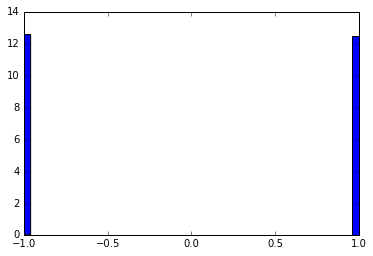

In [451]:
Q = 1
A,P,total_expectative,total_bought = default_setup()
experiment0()

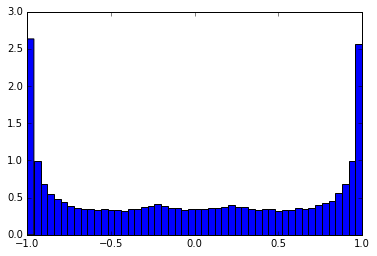

In [452]:
Q = 2
A,P,total_expectative,total_bought = default_setup()
experiment0()

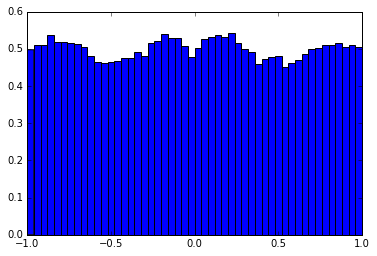

In [453]:
Q = 3
A,P,total_expectative,total_bought = default_setup()
experiment0()

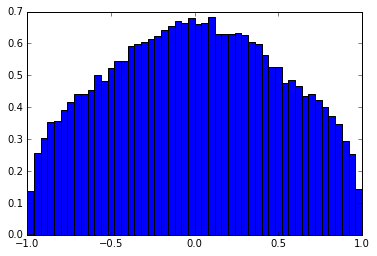

In [454]:
Q = 4
A,P,total_expectative,total_bought = default_setup()
experiment0()

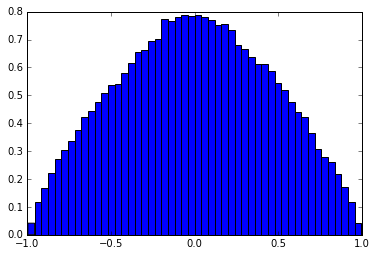

In [455]:
Q = 5
A,P,total_expectative,total_bought = default_setup()
experiment0()

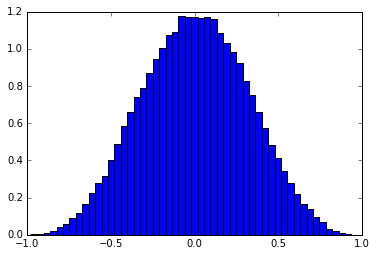

In [456]:
Q = 10
A,P,total_expectative,total_bought = default_setup()
experiment0()

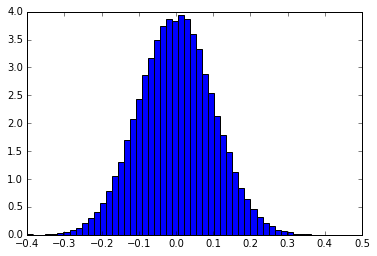

In [457]:
Q = 100
A,P,total_expectative,total_bought = default_setup()
experiment0()

In [354]:
#Experiment 0 Setup
D=10000
S=1
Thresh_type = 'general'
T=0.001
net='lat'
Steps=5000

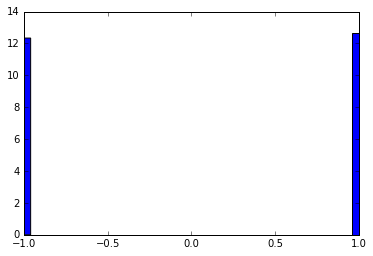

In [355]:
Q = 1
A,P,total_expectative,total_bought = default_setup()
experiment0()

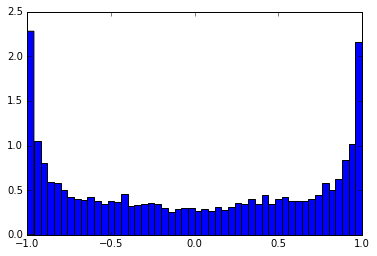

In [356]:
Q = 2
A,P,total_expectative,total_bought = default_setup()
experiment0()

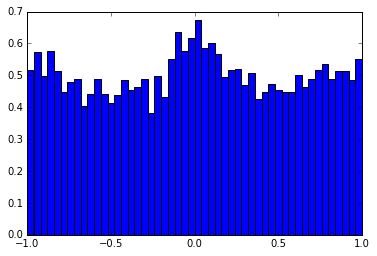

In [357]:
Q = 3
A,P,total_expectative,total_bought = default_setup()
experiment0()

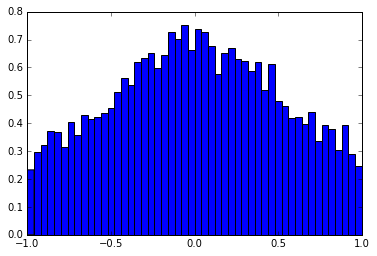

In [358]:
Q = 4
A,P,total_expectative,total_bought = default_setup()
experiment0()

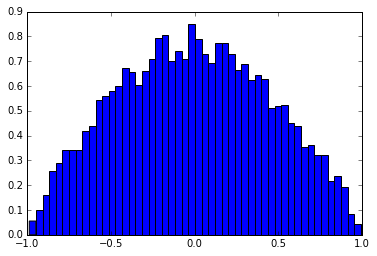

In [359]:
Q = 5
A,P,total_expectative,total_bought = default_setup()
experiment0()

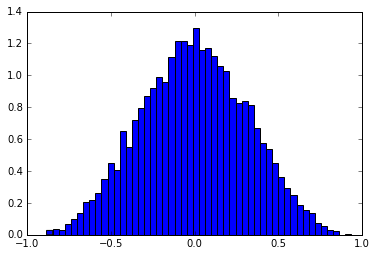

In [360]:
Q = 10
A,P,total_expectative,total_bought = default_setup()
experiment0()

# Results  - Experiment 0

For Lattice and Circle a Q of 1 generates a binomial distribution. After closer inspection this comes from the normalization procedure, norm 1 of a 1 dimension vector is always 1.

Beyond the binomial output of normalization, lower Q values 2-3 tend to form a bimodal distribution where the extremes are more the most common.

As Q increases the distribution adopts a gaussian bell shape, where higher Q increases the median probability and standard deviation decreases.

# Experiment 1

Normal run, all agents build expectations and buy if expectations surpass a random threshold (T).

There are two types of Thresholds: 1) A fixed exogenous value given to all agents. 2) An individual value for each agent (given by a uniform distribution).

Every agent in A has a Threshold value T within the range of -1 and 1. The value is given by a uniform probability distribution.



In [526]:
#Experiment 1

D=100
S=1
Q=10
#Two type of T: 1) 'general' : fixed T for all agents. 2) 'individual' : depends on each agent's threshold.
Thresh_type = 'individual'
net='circle'
Steps=5000

Product 0


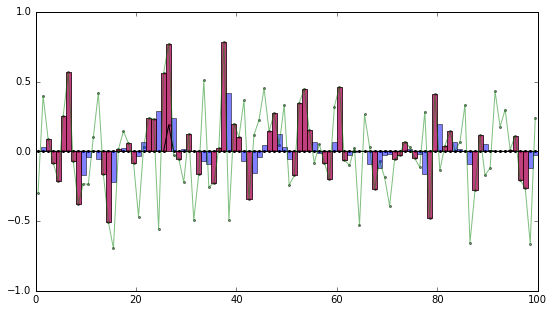

Product 0


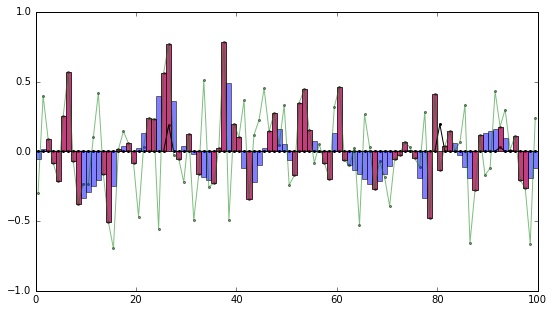

Product 0


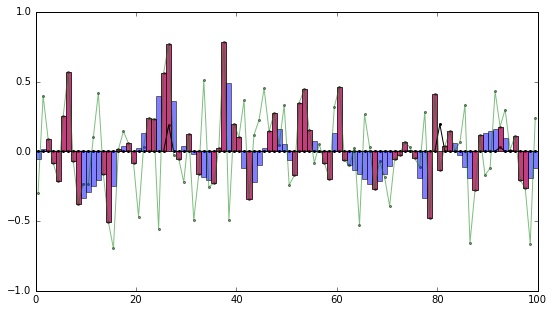

Product 0


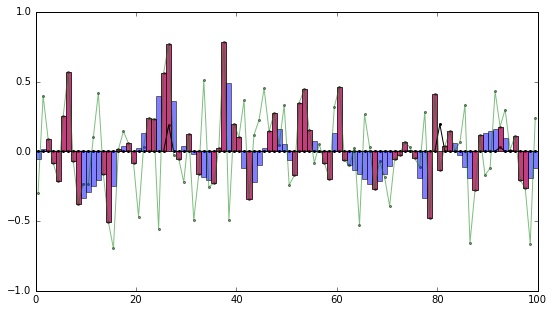

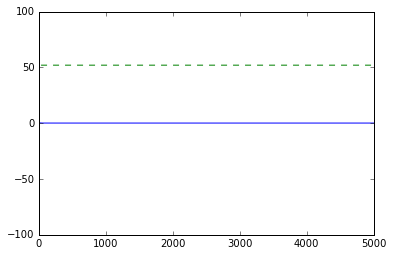

In [527]:
#Variation 1

#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Run simulation
sim_go(Steps,A,P)

Agent's individual T above 0 , as expected by the uniform distribution half of the population has a value over 0. Thus, 50% buy the product at step 0 and generate a realized expectation. 

Those agents surrounded by negative realizations are blocked and will not adopt. Agents surrounded by positive realizations may increase their expectations and are more likely to trigger an adoption if they go over their threshold.

In [507]:
#Experiment 1 in Latice

D=100
S=1
#Two type of T: 1) 'general' : fixed T for all agents. 2) 'individual' : depends on each agent's threshold.
Thresh_type = 'individual'
net='lat'
Steps=5000

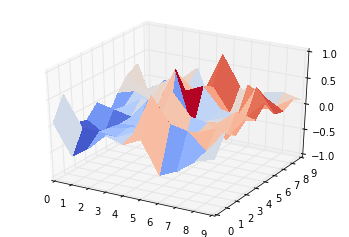

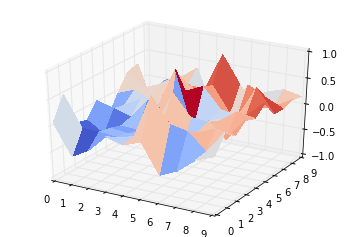

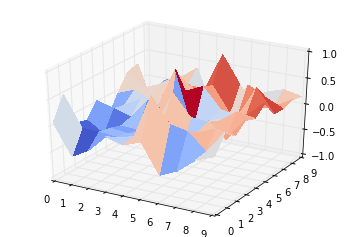

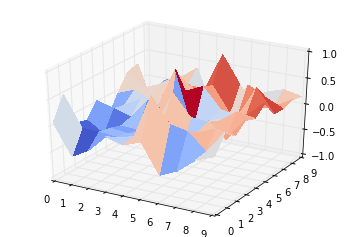

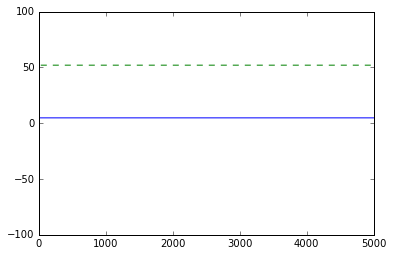

In [508]:
#Latice Variation 1

#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Run simulation
sim_go(Steps,A,P)

# Experiment 2

Test expectation formation with 1 fixed individual.

Variation 1: Agent 50 realized expectation is fixed at 1. Other agents update their expectations and buy.

Variation 2: Agent 50 realized expectation is fixed at -1. Other agents update their expectations and buy.

Variation 3: Agent 50 realized expectation is fixed at 1. Other agents can't buy and only update expectations.

Variation 4: Agent 50 realized expectation is fixed at -1. Other agents can't buy and only update expectations.

In [509]:
#Experiment 2

D=100
S=1
Thresh_type = 'general'
T=0
net='circle'
Steps=5000

Product 0


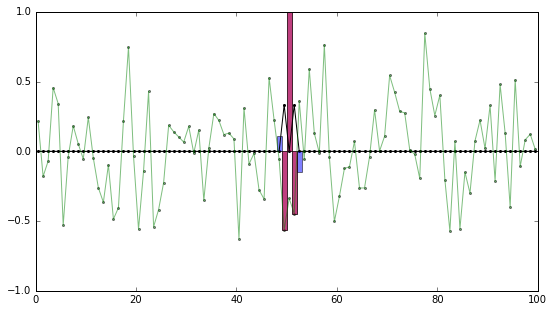

Product 0


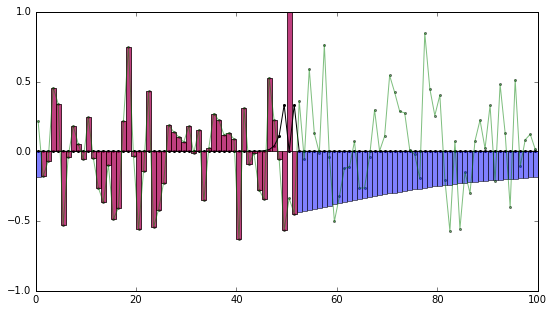

Product 0


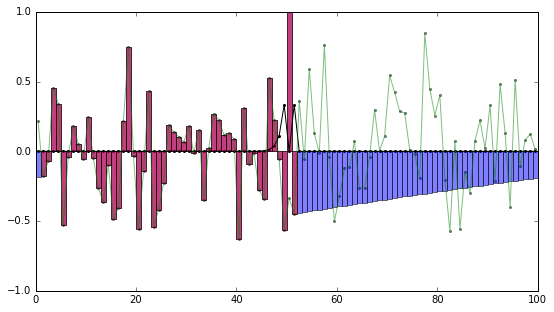

Product 0


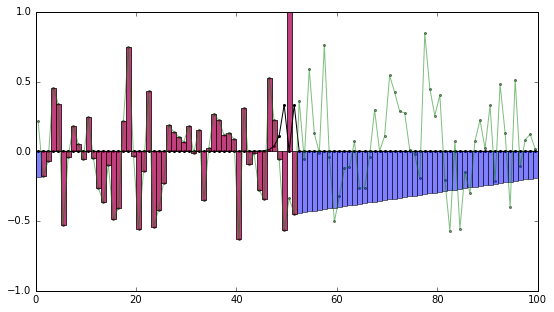

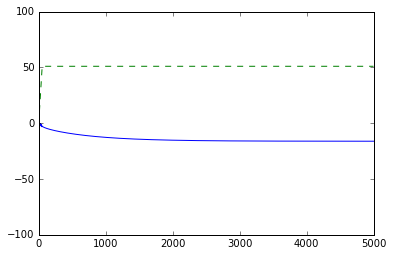

In [510]:
#Variation 1

#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[50].buy(0)
A[50].expectative[0] = 1

#Run simulation
sim_go(Steps,A,P)

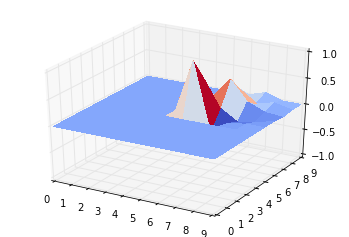

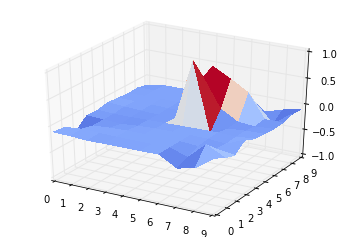

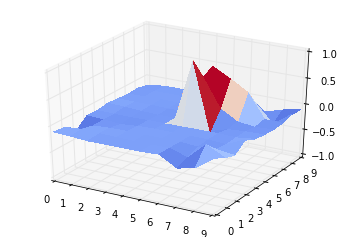

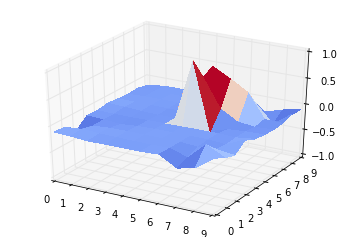

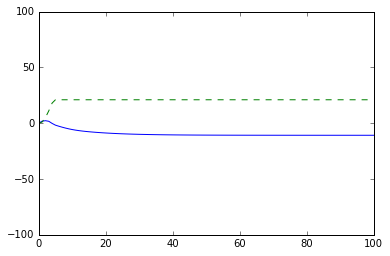

In [511]:
#Latice Variation 1

net='lat'
Steps = 100
#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[55].buy(0)
A[55].expectative[0] = 1

#Run simulation
sim_go(Steps,A,P)

Product 0


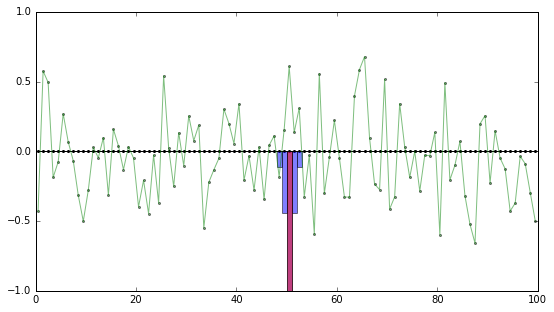

Product 0


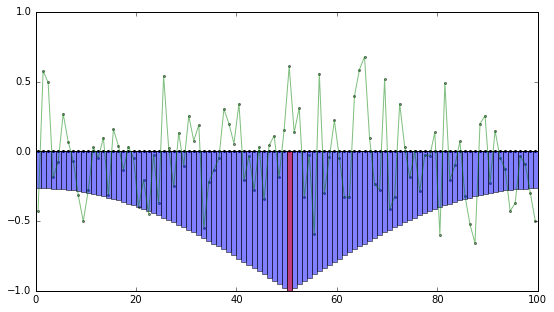

Product 0


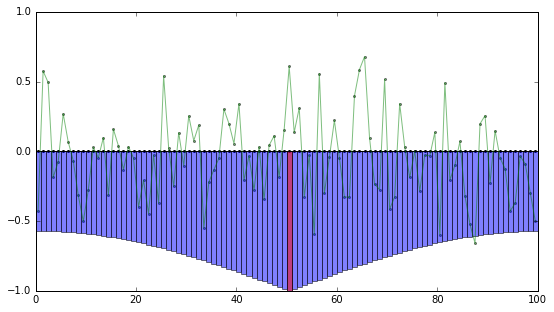

Product 0


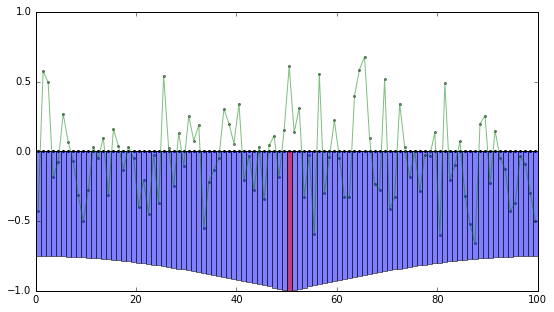

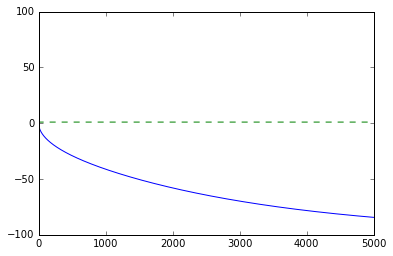

In [512]:
#Variation 2
net = 'circle'
Steps = 5000
#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[50].buy(0)
A[50].expectative[0] = -1

#Run simulation
sim_go(Steps,A,P)

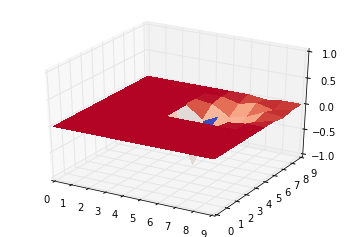

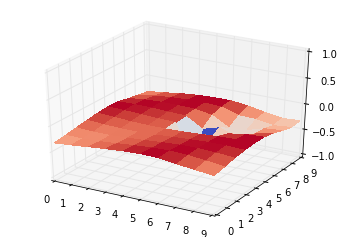

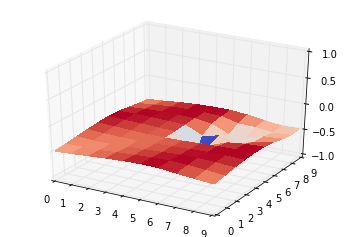

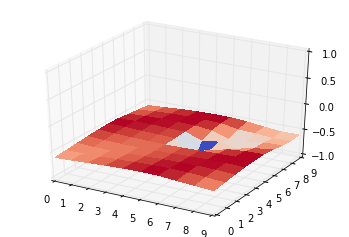

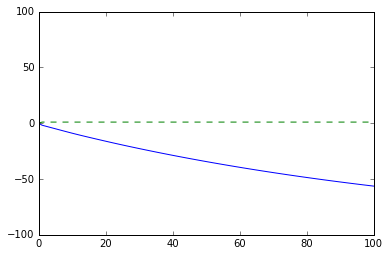

In [513]:
#Latice Variation 2
net = 'lat'
Steps = 100
#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[55].buy(0)
A[55].expectative[0] = -1

#Run simulation
sim_go(Steps,A,P)

As negative realizations can't influence positive expectations the information cascade just follows a decay in expectations.

Product 0


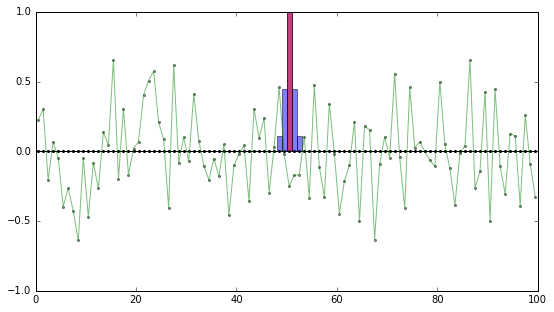

Product 0


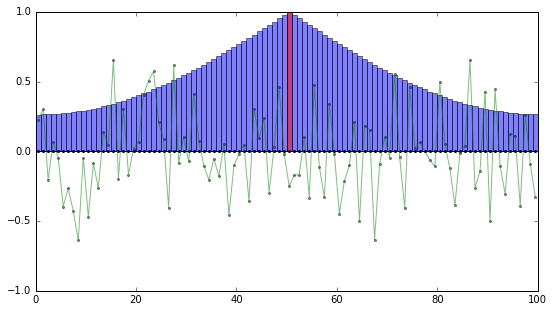

Product 0


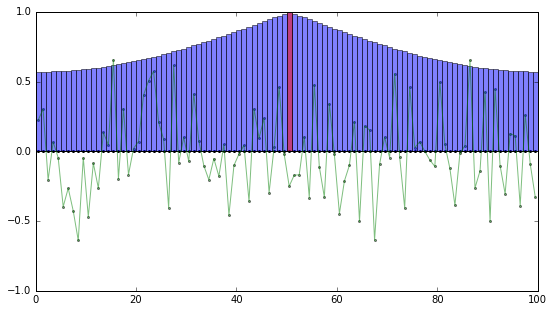

Product 0


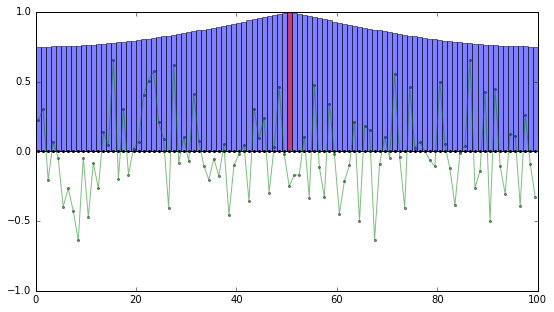

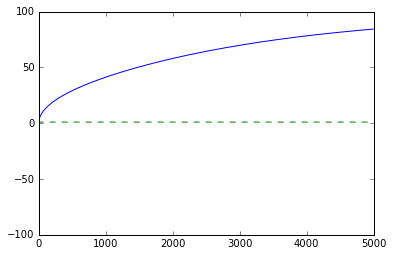

In [514]:
#Variation 3
T = 1
net = 'circle'
Steps = 5000

#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[50].buy(0)
A[50].expectative[0] = 1

#Run simulation
sim_go(Steps,A,P)

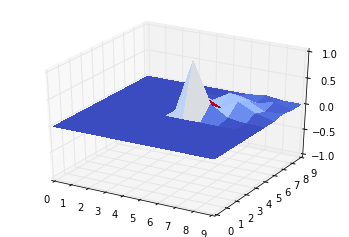

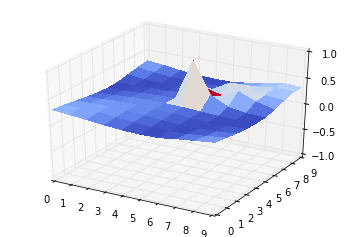

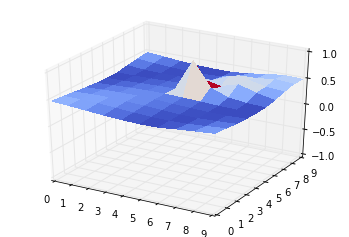

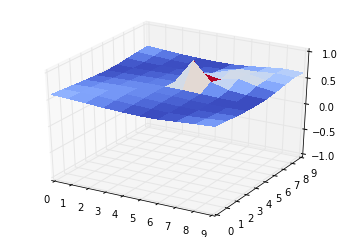

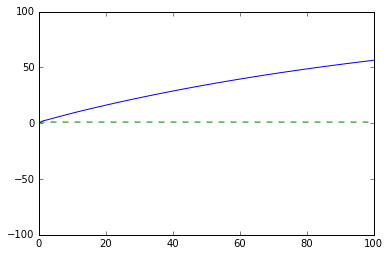

In [516]:
#Latice Variation 3
T = 1
net = 'lat'
Steps = 100

#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[55].buy(0)
A[55].expectative[0] = 1

#Run simulation
sim_go(Steps,A,P)

Product 0


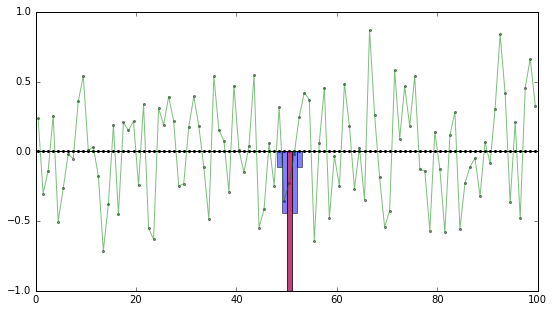

Product 0


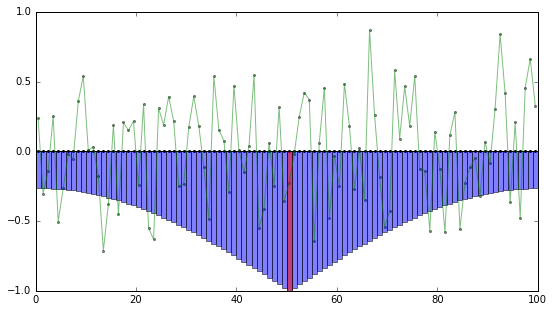

Product 0


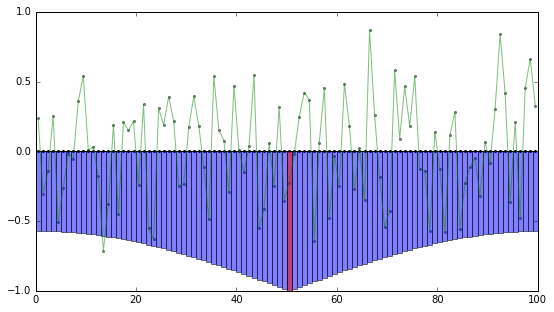

Product 0


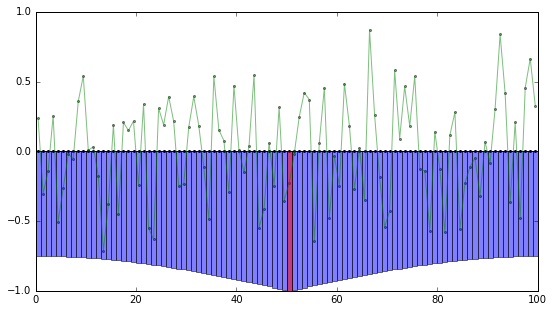

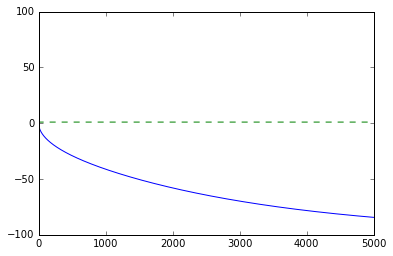

In [517]:
#Variation 4
T = 1
net = 'circle'
Thresh_type = 'general'
Steps = 5000
#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[50].buy(0)
A[50].expectative[0] = -1

#Run simulation
sim_go(Steps,A,P)

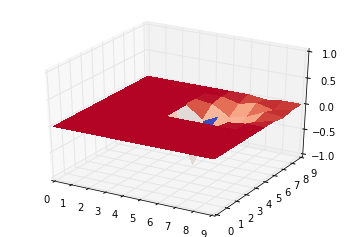

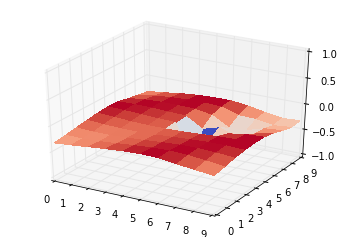

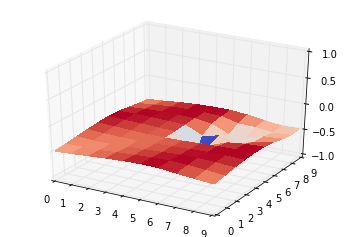

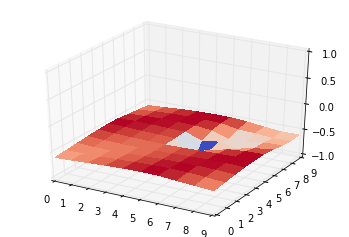

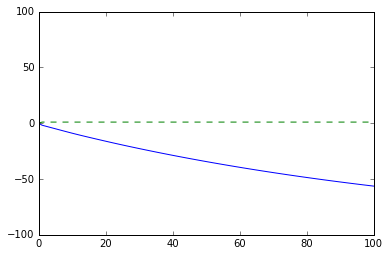

In [518]:
#Latice Variation 4
T = 1
net = 'lat'
Steps = 100

#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[55].buy(0)
A[55].expectative[0] = -1

#Run simulation
sim_go(Steps,A,P)

# Experiment 3

Test what happens when buying is only available at a later simulation step.

Variation 1: Test for 1 super-hyped individual and purchase available at and after 1/3 of the total steps.

Variation 2: Test Variation 1 with a fixed negative realized expectation.

Notice that time steps and product availability varies from Lattice and Circle layouts. 

Product 0


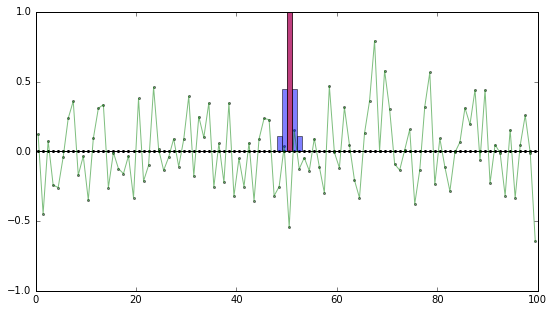

Product 0


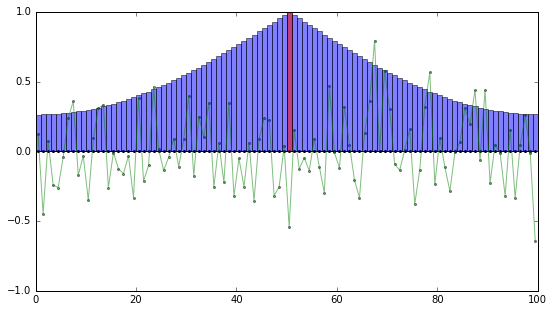

Product 0


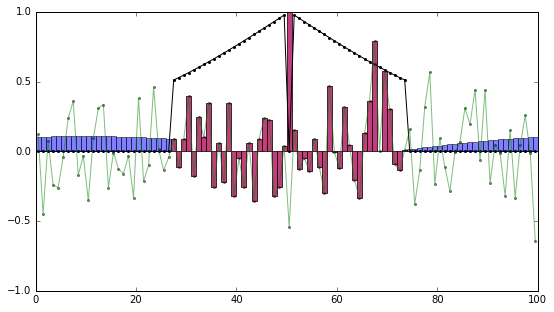

Product 0


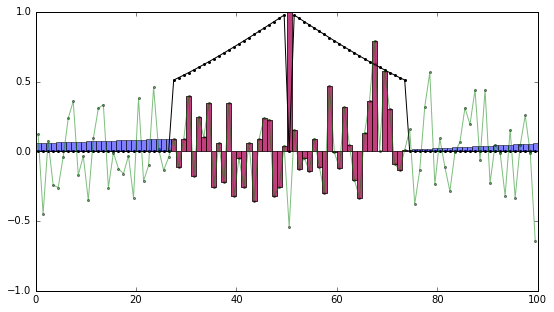

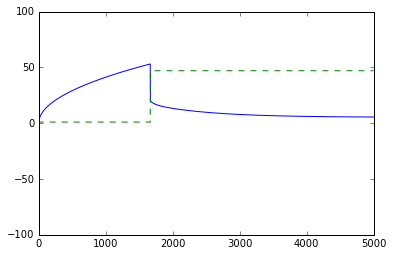

In [519]:
D=100
S=1
Thresh_type = 'general'
T=0.5
net='circle'
Steps=5000
buyable = []

#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[50].buy(0)
A[50].expectative[0] = 1

#Run simulation
sim_go(Steps,A,P,go=int(Steps/3))

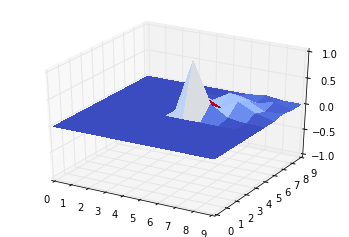

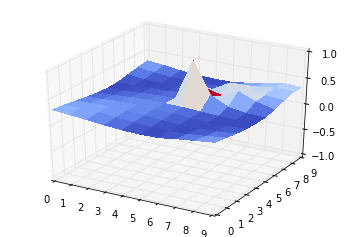

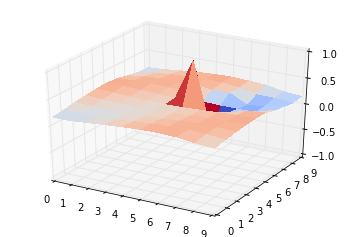

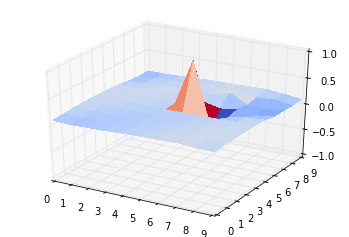

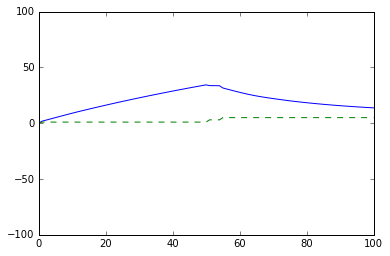

In [520]:
D=100
S=1
Thresh_type = 'general'
T=0.5
net='lat'
Steps=100
buyable = []

#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[55].buy(0)
A[55].expectative[0] = 1

#Run simulation
sim_go(Steps,A,P,go=int(Steps/2))

A higher expectation velocity makes a bigger impact when experience corrects the expectation. This phenomenon is common in the big busts of hyped products. 

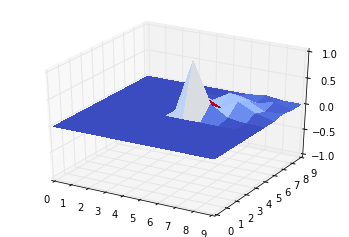

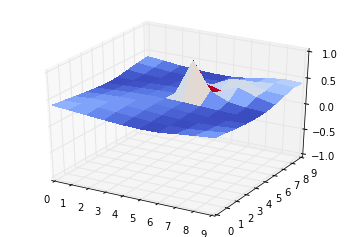

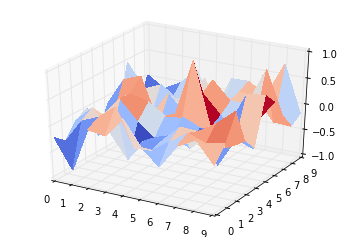

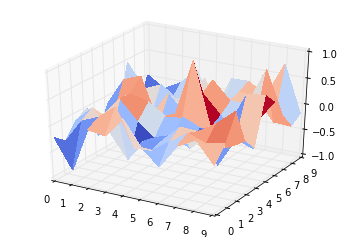

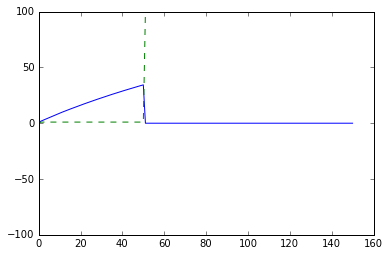

In [521]:
D=100
S=1
Thresh_type = 'general'
T=-0.5
net='lat'
Steps=150
buyable = []

#Setup with given parameters
A,P,total_expectative,total_bought = default_setup()

#Make agent 50 have a realized expectative of 1
A[55].buy(0)
A[55].expectative[0] = 1

#Run simulation
sim_go(Steps,A,P,go=int(Steps/3))